# Boilerplate notebook

In [1]:
# Matplotlib
import matplotlib.pyplot as plt
# Numpy
import numpy as np
# Pillow
from PIL import Image
# Torch
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary
# Misc
import time
from datetime import datetime

# 1. Download dataset

In [2]:
!git clone -b data https://github.com/Oxiang/50.039-Deep-Learning.git

fatal: destination path '50.039-Deep-Learning' already exists and is not an empty directory.


In [3]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [4]:
cd 50.039-Deep-Learning

/content/50.039-Deep-Learning


In [5]:
%%bash

(
tree dataset -d
) 

dataset
├── test
│   ├── infected
│   │   ├── covid
│   │   └── non-covid
│   └── normal
├── train
│   ├── infected
│   │   ├── covid
│   │   └── non-covid
│   └── normal
└── val
    ├── infected
    │   ├── covid
    │   └── non-covid
    └── normal

15 directories


# 2. Dataset high-level info

The images stored in the **./dataset** folder and its subfolder consists of 150 by 150 pixels greyscale images, representing X-Ray pictures of lungs.

The images, consists of X-ray pictures of the following:

| Description                              | Class index | Tensor  | Class label        |
| ---------------------------------------- | ----------- | ------- | ------------------ |
| People with no infection diagnosis       | 0           | [1 0 0] | normal             |
| People with infected lungs and covid     | 1           | [0 1 0] | infected_covid     |
| People with infected lungs and non-covid | 2           | [0 0 1] | infected_non_covid |




In [6]:
classes = {0: 'normal', 1: 'infected_non_covid', 2: 'infected_covid'}
groups = ['train', 'test', 'val']
dataset_numbers = {
    'train_normal': 1341,
    'train_infected_covid': 1345,
    'train_infected_non_covid': 2530,
    'val_normal': 8,
    'val_infected_covid': 8,   
    'val_infected_non_covid': 8,
    'test_normal': 234,
    'test_infected_covid': 138,
    'test_infected_non_covid': 242,
}
dataset_paths = {
    'train_normal': './dataset/train/normal/',
    'train_infected_covid': './dataset/train/infected/covid/',
    'train_infected_non_covid': './dataset/train/infected/non-covid/',
    'val_normal': './dataset/val/normal/',
    'val_infected_covid': './dataset/val/infected/covid/', 
    'val_infected_non_covid': './dataset/val/infected/non-covid/',
    'test_normal': './dataset/test/normal/',
    'test_infected_covid': './dataset/test/infected/covid/', 
    'test_infected_non_covid': './dataset/test/infected/non-covid/',
}

View one of the images and its properties. These images consist of a Numpy array, with values ranging between 0 and 255. These values will be normalized.

Image shape is: (150, 150)
Image as a numpy array is:
 [[15 25 33 ... 30 26 19]
 [16 25 33 ... 30 25 19]
 [17 26 34 ... 29 25 19]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


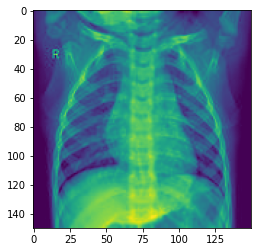

In [7]:
path_to_file = './dataset/train/normal/1.jpg'
with open(path_to_file, 'rb') as f:
    im = np.asarray(Image.open(f))
    plt.imshow(im)
f.close()
print('Image shape is: {}'.format(im.shape))
# Images are defined as a Numpy array of values between 0 and 256
print('Image as a numpy array is:\n {}'.format(im))

# 3. Creating a Dataset object

## 3.1 General Dataset object that is custom made for train, val, test to individually use

length method ( __ len __ )

> return the number of images present in the dataset

getitem method ( __ getitem __ )

> fetch an image and its label, using a single index value. Returns the image, along with a one-hot vector corresponding to the class of the object. Both returned parameters will be torch tensors.
- [1, 0,0] for normal class
- [0, 1, 0] for infected_non_covid class
- [0, 0, 1] for infected_covid class

In [8]:
class Lung_Dataset(Dataset):
    """
    Generic Dataset class.
    """
    
    def __init__(self, groups, dataset_numbers, dataset_paths):
        """
        Constructor for generic Dataset class - assembles
        the important parameters in attributes.

        Parameters
        ----------
        groups : str
            Allowed values: train, val, test
        dataset_numbers : dict
            Count of each class within specified group
        dataset_paths : dict
            Path to each class within specified group
        """

        self.img_size = (150, 150)
        self.classes = {
            0: 'normal',
            1: 'infected_covid',
            2: 'infected_non_covid'
        }        
        self.groups = groups
        self.dataset_numbers = dataset_numbers
        self.dataset_paths = dataset_paths
        
        
    def describe(self):
        """
        Descriptor function.
        Will print details about the dataset when called.
        """
        
        # Generate description
        msg = "This is the {} dataset of the Lung Dataset".format(self.groups)
        msg += " used for the Small Project Demo in the 50.039 Deep Learning class"
        msg += " in March 2021. \n"
        msg += "It contains a total of {} images, ".format(sum(self.dataset_numbers.values()))
        msg += "of size {} by {}.\n".format(self.img_size[0], self.img_size[1])
        msg += "The images are stored in the following locations "
        msg += "and each one contains the following number of images:\n"
        for key, val in self.dataset_paths.items():
            msg += " - {}, in folder {}: {} images.\n".format(key, val, self.dataset_numbers[key])
        print(msg)
        
    
    def open_img(self, group_val, class_val, index_val):
        """
        Opens image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        
        Returns loaded image as a normalized Numpy array.
        """
        
        # Asserts checking for consistency in passed parameters
        err_msg = "Error - group_val variable should be set to 'train', 'test' or 'val'."
        assert group_val in self.groups, err_msg
        
        err_msg = "Error - class_val variable should be set to 'normal' or 'infected_non_covid' or 'infected_covid."
        assert class_val in self.classes.values(), err_msg
        
        max_val = self.dataset_numbers['{}_{}'.format(group_val, class_val)]
        err_msg = "Error - index_val variable should be an integer between 0 and the maximal number of images."
        err_msg += "\n(In {}/{}, you have {} images.)".format(group_val, class_val, max_val)
        assert isinstance(index_val, int), err_msg
        assert index_val >= 0 and index_val <= max_val, err_msg
        
        # Open file as before
        path_to_file = '{}/{}.jpg'.format(self.dataset_paths['{}_{}'.format(group_val, class_val)], index_val)
        with open(path_to_file, 'rb') as f:
            # Convert to Numpy array and normalize pixel values by dividing by 255.
            im = np.asarray(Image.open(f))/255
        f.close()
        return im
    
    
    def show_img(self, group_val, class_val, index_val):
        """
        Opens, then displays image with specified parameters.
        
        Parameters:
        - group_val should take values in 'train', 'test' or 'val'.
        - class_val variable should be set to 'normal' or 'infected'.
        - index_val should be an integer with values between 0 and the maximal number of images in dataset.
        """
        
        # Open image
        im = self.open_img(group_val, class_val, index_val)
        
        # Display
        plt.imshow(im)

    def __len__(self):
        """
        Length special method, returns the number of images in dataset.
        """
        
        # Length function
        return sum(self.dataset_numbers.values())
    
    
    def __getitem__(self, index):
        """
        Getitem special method.
        
        Expects an integer value index, between 0 and len(self) - 1.
        
        Returns the image and its label as a one hot vector, both
        in torch tensor format in dataset.
        """
        
        # Get item special method
        first_val = int(list(self.dataset_numbers.values())[0])
        second_val = int(list(self.dataset_numbers.values())[1])
        if index < first_val:
            class_val = 'normal'
            label = torch.Tensor([1, 0, 0])
        elif index < (first_val+second_val):
            class_val = 'infected_covid'
            index = index - first_val
            label = torch.Tensor([0, 1, 0])
        else:
            class_val = "infected_non_covid"
            index = index - (first_val+second_val)
            label = torch.Tensor([0, 0, 1])
        im = self.open_img(self.groups, class_val, index)
        im = transforms.functional.to_tensor(np.array(im)).float()
        return im, label

In [9]:
dataset_numbers = {
    'train': {
        'train_normal': 1341,
        'train_infected_covid': 1345,
        'train_infected_non_covid': 2530,
    },
    'val': {
        'val_normal': 8,
        'val_infected_covid': 8,
        'val_infected_non_covid': 8,
    },
    'test': {
        'test_normal': 234,
        'test_infected_covid': 138,
        'test_infected_non_covid': 242,
    }
}
dataset_paths = {
    'train': {
        'train_normal': './dataset/train/normal/',
        'train_infected_covid': './dataset/train/infected/covid/',
        'train_infected_non_covid': './dataset/train/infected/non-covid/',
    },
    'val': {
        'val_normal': './dataset/val/normal/',
        'val_infected_covid': './dataset/val/infected/covid/',
        'val_infected_non_covid': './dataset/val/infected/non-covid/',
    },
    'test': {
        'test_normal': './dataset/test/normal/',
        'test_infected_covid': './dataset/test/infected/covid/',
        'test_infected_non_covid': './dataset/test/infected/non-covid/',
    }
}

In [10]:
def verify_dataset(group,dataset,image_overall_index=7,class_val='normal',
                   image_specific_dataset_index=1):
  print('Verify the special methods __len__ and __get_item__')
  print('Number of images in {} dataset: {}'.format(group, len(dataset)))
  print('Details for image id {} from the {} dataset'.format(
      image_overall_index,
      group
  ))
  im, class_oh = dataset[image_overall_index]
  print('Sample image shape: {}'.format(im.shape))
  print('Sample image: {}'.format(im))
  print('Sample image class: {}'.format(class_oh))

  print('\nVerify the open_img and show_img functions')
  print('Open and show image {} from the {}_{} dataset'.format(
      image_specific_dataset_index,
      group,
      class_val
  ))
  im = dataset.open_img(group, class_val, image_specific_dataset_index)
  print('Same sample image shape: {}'.format(im.shape))
  print('Same sample image: {}'.format(im))
  dataset.show_img(group, class_val, image_specific_dataset_index)

## 3.2 Train dataset

In [11]:
train_group = 'train'
ld_train = Lung_Dataset(
    train_group,
    dataset_numbers[train_group],
    dataset_paths[train_group]
)
ld_train.describe()

This is the train dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in March 2021. 
It contains a total of 5216 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - train_normal, in folder ./dataset/train/normal/: 1341 images.
 - train_infected_covid, in folder ./dataset/train/infected/covid/: 1345 images.
 - train_infected_non_covid, in folder ./dataset/train/infected/non-covid/: 2530 images.



Verify the special methods __len__ and __get_item__
Number of images in train dataset: 5216
Details for image id 1 from the train dataset
Sample image shape: torch.Size([1, 150, 150])
Sample image: tensor([[[0.0588, 0.0980, 0.1294,  ..., 0.1176, 0.1020, 0.0745],
         [0.0627, 0.0980, 0.1294,  ..., 0.1176, 0.0980, 0.0745],
         [0.0667, 0.1020, 0.1333,  ..., 0.1137, 0.0980, 0.0745],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])
Sample image class: tensor([1., 0., 0.])

Verify the open_img and show_img functions
Open and show image 1 from the train_normal dataset
Same sample image shape: (150, 150)
Same sample image: [[0.05882353 0.09803922 0.12941176 ... 0.11764706 0.10196078 0.0745098 ]
 [0.0627451  0.09803922 0.12941176 ... 0.11764706 0.09803922 0.0745098 ]
 [0.06666667 0.10196078 0.13333333 ... 0.11372549 0.098039

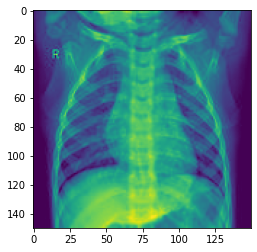

In [12]:
verify_dataset(train_group,ld_train,1)

## 3.3 Validation dataset

In [13]:
val_group = 'val'
ld_val = Lung_Dataset(
    val_group,
    dataset_numbers[val_group],
    dataset_paths[val_group]
)
ld_val.describe()

This is the val dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in March 2021. 
It contains a total of 24 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - val_normal, in folder ./dataset/val/normal/: 8 images.
 - val_infected_covid, in folder ./dataset/val/infected/covid/: 8 images.
 - val_infected_non_covid, in folder ./dataset/val/infected/non-covid/: 8 images.



Verify the special methods __len__ and __get_item__
Number of images in val dataset: 24
Details for image id 1 from the val dataset
Sample image shape: torch.Size([1, 150, 150])
Sample image: tensor([[[0.3216, 0.2000, 0.4431,  ..., 0.0471, 0.0431, 0.0314],
         [0.1216, 0.1176, 0.4039,  ..., 0.0118, 0.0235, 0.0353],
         [0.4941, 0.4157, 0.4471,  ..., 0.0157, 0.0510, 0.0902],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0118, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0196, 0.0078, 0.0039,  ..., 0.0000, 0.0000, 0.0000]]])
Sample image class: tensor([1., 0., 0.])

Verify the open_img and show_img functions
Open and show image 1 from the val_normal dataset
Same sample image shape: (150, 150)
Same sample image: [[0.32156863 0.2        0.44313725 ... 0.04705882 0.04313725 0.03137255]
 [0.12156863 0.11764706 0.40392157 ... 0.01176471 0.02352941 0.03529412]
 [0.49411765 0.41568627 0.44705882 ... 0.01568627 0.05098039 0.090

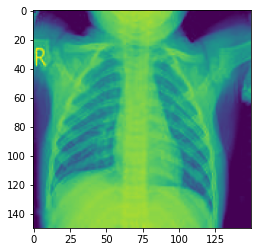

In [14]:
verify_dataset(val_group,ld_val,1)

## 3.4 Test dataset

In [15]:
test_group = 'test'
ld_test = Lung_Dataset(
    test_group,
    dataset_numbers[test_group],
    dataset_paths[test_group]
)
ld_test.describe()

This is the test dataset of the Lung Dataset used for the Small Project Demo in the 50.039 Deep Learning class in March 2021. 
It contains a total of 614 images, of size 150 by 150.
The images are stored in the following locations and each one contains the following number of images:
 - test_normal, in folder ./dataset/test/normal/: 234 images.
 - test_infected_covid, in folder ./dataset/test/infected/covid/: 138 images.
 - test_infected_non_covid, in folder ./dataset/test/infected/non-covid/: 242 images.



Verify the special methods __len__ and __get_item__
Number of images in test dataset: 614
Details for image id 1 from the test dataset
Sample image shape: torch.Size([1, 150, 150])
Sample image: tensor([[[0.1098, 0.1294, 0.1020,  ..., 0.4902, 0.4431, 0.3843],
         [0.1098, 0.1333, 0.1020,  ..., 0.4863, 0.4431, 0.3804],
         [0.1098, 0.1373, 0.1020,  ..., 0.4863, 0.4392, 0.3765],
         ...,
         [0.1216, 0.1647, 0.1647,  ..., 0.1294, 0.1255, 0.1216],
         [0.1216, 0.1647, 0.1647,  ..., 0.1294, 0.1255, 0.1216],
         [0.1216, 0.1647, 0.1647,  ..., 0.1294, 0.1255, 0.1216]]])
Sample image class: tensor([1., 0., 0.])

Verify the open_img and show_img functions
Open and show image 1 from the test_normal dataset
Same sample image shape: (150, 150)
Same sample image: [[0.10980392 0.12941176 0.10196078 ... 0.49019608 0.44313725 0.38431373]
 [0.10980392 0.13333333 0.10196078 ... 0.48627451 0.44313725 0.38039216]
 [0.10980392 0.1372549  0.10196078 ... 0.48627451 0.43921569 0

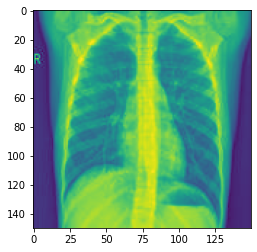

In [16]:
verify_dataset(test_group,ld_test,1)

# 4. Data visualization

This requires a `grouped bar chart`. Refer to [matplotlib Grouped bar chart with labels](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html) for starter code

<u>**Discuss whether or not the dataset is balanced between classes, uniformly distributed, etc.**</u>

**Training set**

The train data for the different classes are imbalanced. From the graph plotted below, the `infected_non_covid` class has significantly more data points than the other classes. Overall, the ratio `normal:infected_non_covid:infected_covid` is approximately `1:2:1`.

This could present more complications if the model is trained in a stacking manner by first training normal vs infected. The ratio of `normal:infected` would be a ratio of `1:3` which is more imbalanced.

**Testing set**

The test set is also slightly imbalanced with the ratio `normal:infected_non_covid:infected_covid` being approximately `2:2:1`. However, this is not as bad as an imbalanced training set because the test set will not affect the model's parameter tuning.

**Validation set**

The val set is uniformly distributed between the three classes. However, it is glaring that there are only 8 validation samples for the 3 classes. Considering the ratio of `train:val:test`, the number of validation samples is far too low. For example. with reference to the infected_non_covid class, the ratio of `train:val:test` is `316:1:30`. which is quite far off from the recommended ratios like `80:10:10` or `8:1:1` as indicated by [Stanford's CS230](https://cs230.stanford.edu/blog/split/).

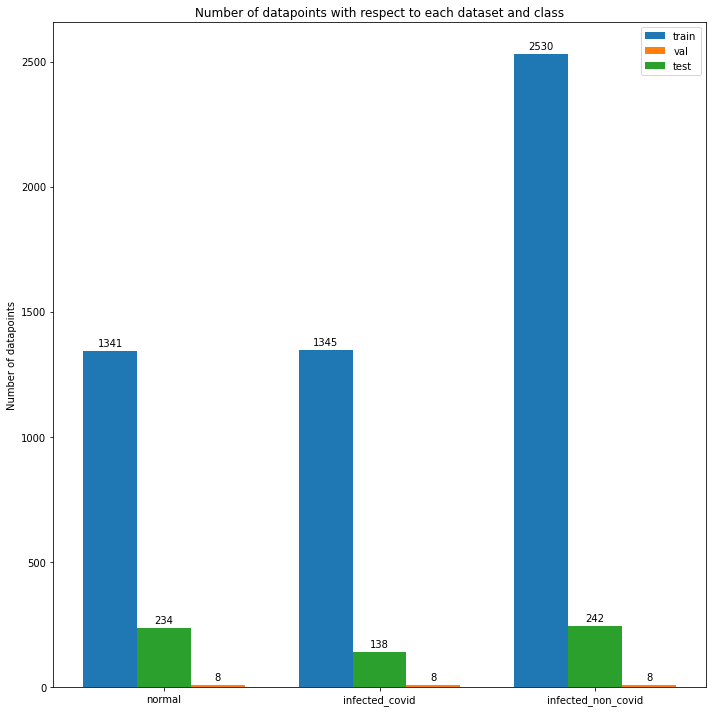

In [17]:
labels = ['normal', 'infected_covid', 'infected_non_covid']

train_normal_inc_ic = list(ld_train.dataset_numbers.values())
val_normal_inc_ic = list(ld_val.dataset_numbers.values())
test_normal_inc_ic = list(ld_test.dataset_numbers.values())

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(10,10))
rects1 = ax.bar(x - width, train_normal_inc_ic, width, label='train')
rects2 = ax.bar(x + width, val_normal_inc_ic, width, label='val')
rects3 = ax.bar(x, test_normal_inc_ic, width, label='test')

ax.set_ylabel('Number of datapoints')
ax.set_title('Number of datapoints with respect to each dataset and class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()
plt.show()

# 4. Why normalize the data?

To recap the normalization can be found in the `Lung_Dataset` class' `open_img` function which did the following normalization.

```python
# Convert to Numpy array and normalize pixel values by dividing by 255.
im = np.asarray(Image.open(f))/255
```

Images have RGB ranges from 0-255. Considering various activation functions like `sigmoid` such a large range would mean that for vastly different values like 100 and 255, not much difference can be seen when passed into the `sigmoid` activation function. Both would produce a value that is close to 1.

Taking the same values as reference, if we divide by 255, for a value of 100,  $\frac{100}{255}$ we get approximately 0.39. Then for a value of 255, $\frac{255}{255}$ we get 1. For the initial value of 100 that becomes 0.39 after the division, passing it into `sigmoid(0.39)` produces a value of 0.596. Meanwhile for the initial value of 255 that becomes 1 after division, passing it into `sigmoid(1)` produces a value of 0.731. This difference in value allows us to extract meaningful differences in the pixel values.


# 5. Other possible pre-processing

Form the plot below, which is based on the Training set for normal images as reference, it is evident that there are several differences in the photo dimensions and photo environment. 

For example, comparing image_index 1 and image_index 28 there is a clear difference in the lighting, Image_index 28 is a lot brighter. One pre-processing step could be to use histogram normalization. There is a paper that recommends 14 possible normalization algorithms that can be performed (Leszczynski, 2010)

Aother example is comparing "skinny" images like image_index 1 and image_index 31 where there is significantly more dark backgrounds at the side compares to images like image_index 12. Perhaps a edge detection algorithm can be applied to just filter the relevant parts of the image which are the lungs.

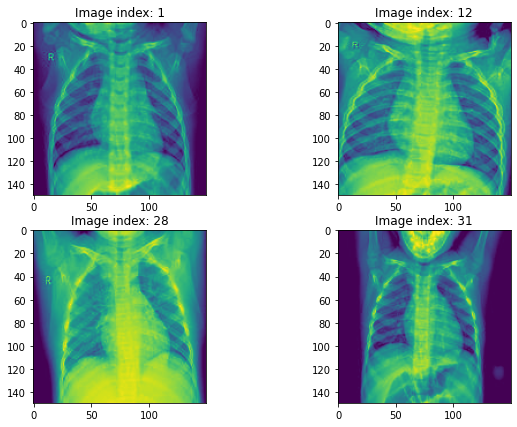

In [18]:
row = 2
col = 2

selected_indices = [1,12,28,31]
f, axarr = plt.subplots(row,col,figsize=(10,7))
counter = 0
for row_index in range(row):
  for col_index in range(col):
    image_index = selected_indices[counter]
    im = ld_train.open_img('train', 'normal', image_index)
    axarr[row_index,col_index].set_title('Image index: {}'.format(image_index))
    axarr[row_index,col_index].imshow(im)
    counter += 1

# 6. Creating a data loader object

In [19]:
bs_val = 32
train_loader = DataLoader(ld_train, batch_size = bs_val, shuffle = True)
test_loader = DataLoader(ld_test, batch_size = bs_val, shuffle = True)
val_loader = DataLoader(ld_val, batch_size = 1, shuffle = True)

# 7. Model



In [20]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Conv2D: 1 input channel, 4 output channels, 3 by 3 kernel, stride of 1.
        self.conv1 = nn.Conv2d(1, 4, 3, 1)
        # change the linear layer to output 3 dim
        self.fc1 = nn.Linear(87616, 3)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim = 1)
        return output

In [21]:
# Activate gpu
if torch.cuda.is_available():  
    print('using GPU')
    device = "cuda:0" 
else:  
    device = "cpu"
model = Net().to(torch.device(device))

using GPU


In [22]:
summary(model, (1, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 148, 148]              40
            Linear-2                    [-1, 3]         262,851
Total params: 262,891
Trainable params: 262,891
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.09
Forward/backward pass size (MB): 0.67
Params size (MB): 1.00
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


# 8. Training the model

Reference material: [Towards data science: PyTorch [Tabular] — Multiclass Classification](https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab)

In [23]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    return acc

In [24]:
# Define criterion and optimizer, epoch
epochs = 5
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [26]:
start = time.time()
messages = []

accuracy_stats_epoch = {
    'train': [],
    'test': [],
    'epoch': [],
}
loss_stats_epoch = {
    'train': [],
    'test': [],
    'epoch': [],
}

for e in range(epochs):
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        

        optimizer.zero_grad()

        output = model.forward(X_train_batch)
        train_loss  = criterion(output, torch.max(y_train_batch, 1)[1])
        train_acc = multi_acc(output, torch.max(y_train_batch, 1)[1])
        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
   
    with torch.no_grad():
        test_epoch_loss = 0
        test_epoch_acc = 0
        model.eval()
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

            y_test_pred = model.forward(X_test_batch)

            test_loss = criterion(y_test_pred, torch.max(y_test_batch, 1)[1])
            test_acc = multi_acc(y_test_pred, torch.max(y_test_batch, 1)[1])

            test_epoch_loss += test_loss.item()
            test_epoch_acc += test_acc.item()
    # averaged
    train_epoch_loss = train_epoch_loss/len(train_loader)
    train_epoch_acc = train_epoch_acc/len(train_loader)
    test_epoch_loss = test_epoch_loss/len(test_loader)
    test_epoch_acc = test_epoch_acc/len(test_loader)
      
    # The step number corresponds to the number of batches seen
    now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    msg = "Epoch: {}/{} - {} - ".format(e+1, epochs, now)
    msg += "Training Loss: {:.4f} - ".format(train_epoch_loss)
    msg += "Training Accuracy: {:.4f} - ".format(train_epoch_acc)
    msg += "Test Loss: {:.4f} - ".format(test_epoch_loss)
    msg += "Test Accuracy: {:.4f}".format(test_epoch_acc)
    messages.append(msg)
    print(msg)
    model.train()
      
    # Epoch metrics
    loss_stats_epoch['train'].append(train_epoch_loss)
    loss_stats_epoch['test'].append(test_epoch_loss)
    loss_stats_epoch['epoch'].append(e+1)
    accuracy_stats_epoch['train'].append(train_epoch_acc)
    accuracy_stats_epoch['test'].append(test_epoch_acc)
    accuracy_stats_epoch['epoch'].append(e+1)
# autosave model
end_model_time = datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
model_name = 'boilerplate_net'
# auto-save a checkpoint at every epoch for evaluation and continual training. Overrides the previous checkpoint
checkpoint = {
    'epochs': e+1,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': train_epoch_loss,
    'test_loss': test_epoch_loss,
    'test_accuracy': test_epoch_acc,
    'training_accuracy': train_epoch_acc
}
path = './model_{}_{}_{}'.format(epochs, model_name, end_model_time)
torch.save(checkpoint, path)

Epoch: 1/5 - 21/03/2021 10:19:09 - Training Loss: 0.4858 - Training Accuracy: 0.7860 - Test Loss: 0.9286 - Test Accuracy: 0.6776
Epoch: 2/5 - 21/03/2021 10:19:12 - Training Loss: 0.4703 - Training Accuracy: 0.7905 - Test Loss: 1.2101 - Test Accuracy: 0.5750
Epoch: 3/5 - 21/03/2021 10:19:15 - Training Loss: 0.4543 - Training Accuracy: 0.8004 - Test Loss: 1.0001 - Test Accuracy: 0.5938
Epoch: 4/5 - 21/03/2021 10:19:18 - Training Loss: 0.4244 - Training Accuracy: 0.8121 - Test Loss: 1.0483 - Test Accuracy: 0.6458
Epoch: 5/5 - 21/03/2021 10:19:21 - Training Loss: 0.4318 - Training Accuracy: 0.8081 - Test Loss: 1.0907 - Test Accuracy: 0.6219


In [27]:
mkdir -p results && mkdir -p results/experiments && mkdir -p results/experiments/architecture_selection

In [28]:
with open('{}'.format('./results/experiments/architecture_selection/multi__net.txt'), 'w') as f:
  for msg in messages:
      f.write('{}\n'.format(msg))

# 9. Graph visualizations of learning curves

Graphs covered

1. Accuracy against steps
2. Recall against steps
3. Precision against steps
4. F1 against steps
5. Loss against steps

In [29]:
def plot_graph(data,datasets,y_axis,x_axis):
  """Plots a graph of y against x

    Keyword arguments:
    data -- dictionary with keys: train, test, epoch
    datasets -- list of datasets to plot: train, test
    y_axis -- name of the y_axis. example: accuracy
    x_axis -- epoch
    """
  plt.figure(figsize=(17,8))
  for dataset in datasets:
    target_y = data[dataset]
    target_x = data[x_axis]
    plt.plot(target_x, target_y, label = dataset)
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.title('Graph of {} against {}'.format(y_axis, x_axis))
  plt.legend()
  plt.show()

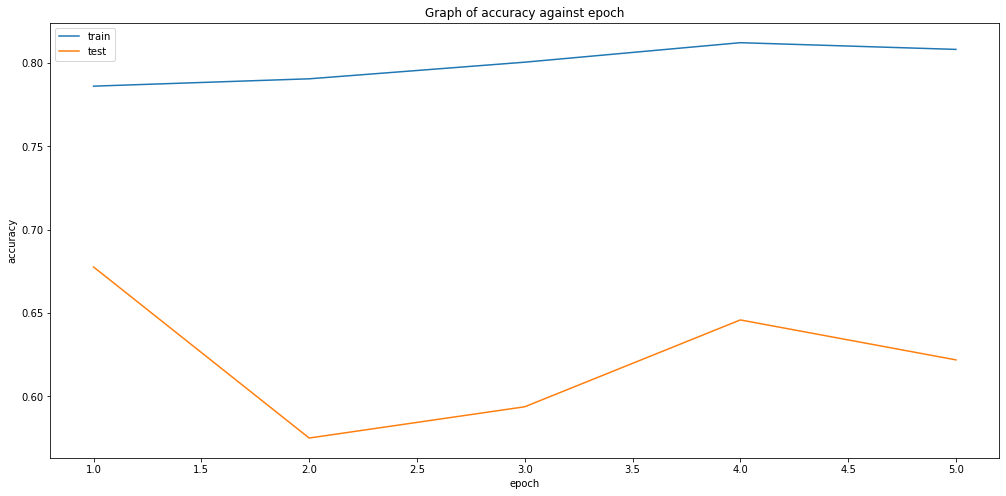

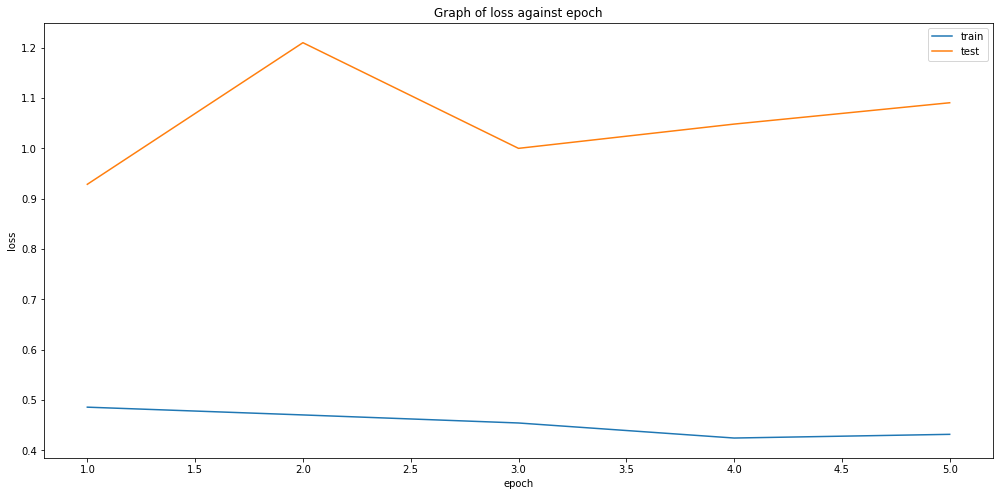

In [30]:
plot_graph(accuracy_stats_epoch, ['train', 'test'], 'accuracy', 'epoch')
plot_graph(loss_stats_epoch, ['train', 'test'], 'loss', 'epoch')

# 10. Validation set performance

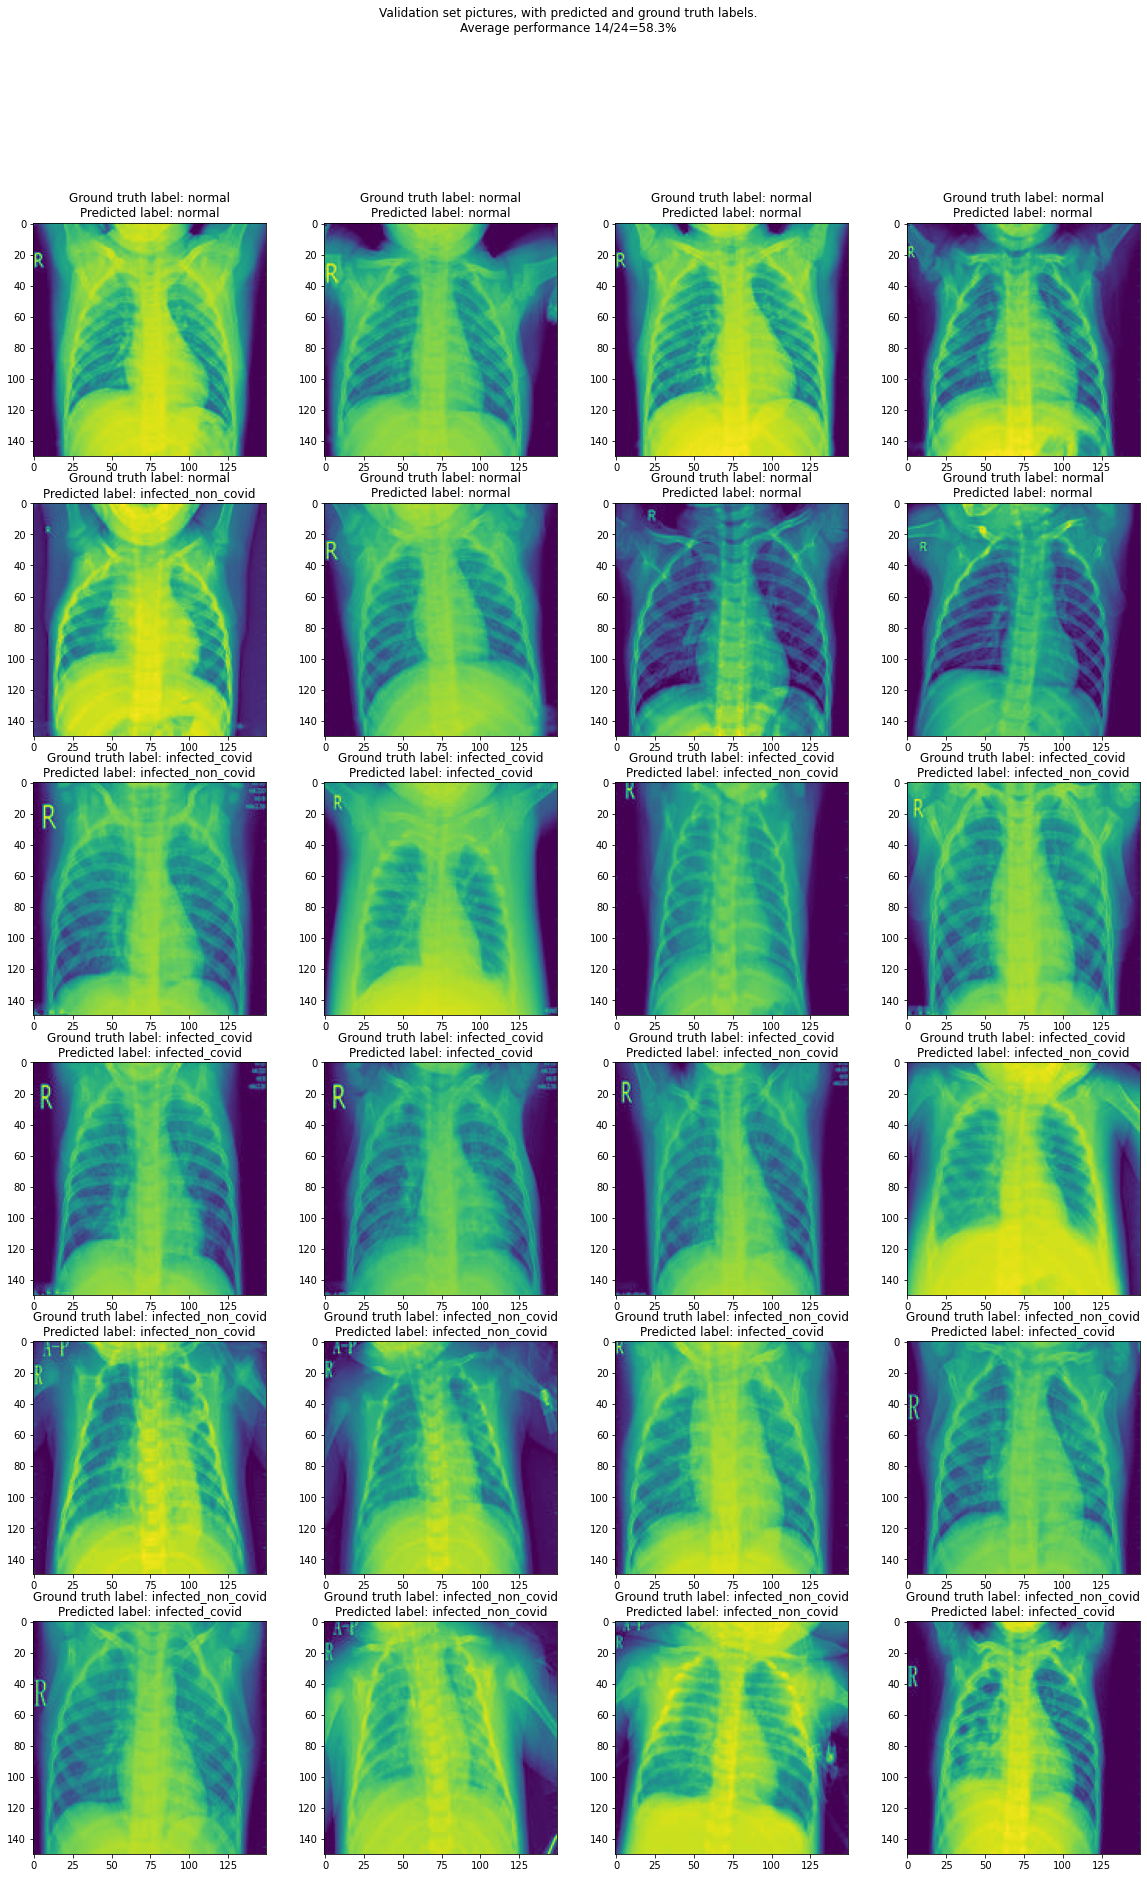

In [31]:
def get_ground_truth_prediction(data_loader):
    '''Gets the predicted & ground truth labels for each image in data_loader

    Keyword arguments:
    data_loader -- data loader object
    '''
    correct = 0
    result = {
        'im': [],
        'ground_truth': [],
        'prediction': [],
        'index': []
    }
    for batch_idx, (X_val_batch, ground_truth) in enumerate(data_loader):
        ground_truth = torch.max(ground_truth,1)[1].item()
        ground_truth = ld_val.classes.get(ground_truth)
        prediction = model.forward(X_val_batch.to(device))
        prediction = torch.max(prediction,1)[1].item()
        prediction = ld_val.classes.get(prediction)
        if ground_truth == prediction:
          correct += 1
        im, class_oh = ld_val[batch_idx]
        result['im'].append(im)
        result['ground_truth'].append(ground_truth)
        result['prediction'].append(prediction)
        result['index'].append(batch_idx)
    return result, correct

def plot_ground_truth_prediction(row, col, result):
    '''Plots the subplots of images with their ground truth and prediction

    Keyword arguments:
    row -- integer value for number of rows of plot
    col -- integer value for number of columns of plot
    result -- dictionary containing index, prediction, ground truth, image
    '''
    f, axarr = plt.subplots(row,col,figsize=(20,30))
    f.suptitle('Validation set pictures, with predicted and ground truth labels.\nAverage performance {}/{}={}%'.format(correct,total,accuracy))
    counter = 0
    for row_index in range(row):
        for col_index in range(col):
            axarr[row_index,col_index].set_title(
                'Ground truth label: {}\nPredicted label: {}'.format(
                    result['ground_truth'][counter],
                    result['prediction'][counter])
                )
            axarr[row_index,col_index].imshow(torch.squeeze(result['im'][counter]))
            counter += 1

val_loader = DataLoader(ld_val, batch_size = 1, shuffle = False)
total = len(val_loader)
result, correct = get_ground_truth_prediction(val_loader)
accuracy = round(correct/total,3) * 100
row = 6
col = 4

plot_ground_truth_prediction(row, col, result)

combined accuracy: 0.5833333333333334


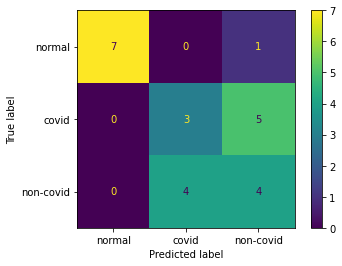

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
val_loader = DataLoader(ld_val, batch_size = 1, shuffle = False)

acc = 0
# row = truth, col = pred
y_true = []
y_pred = []
for X_val_batch, y_val_batch in val_loader:
    X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
    
    model.eval()
    y_val_pred = model.forward(X_val_batch.to(device))
    y_val_pred = int(torch.max(y_val_pred, 1)[1])
    if y_val_pred == 0:
        # normal
        y_val_pred = torch.Tensor([1, 0, 0])
    elif y_val_pred == 1:
        y_val_pred = torch.Tensor([0, 1, 0])
    else:
        y_val_pred = torch.Tensor([0, 0, 1])
        
    y_val_pred = y_val_pred.to(device)
    batch_acc = int(torch.argmax(y_val_batch)) == int(torch.argmax(y_val_pred))
    y_true.append(int(torch.argmax(y_val_batch)))
    y_pred.append(int(torch.argmax(y_val_pred)))
    acc += batch_acc
    
print('combined accuracy:', acc/len(val_loader))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['normal','covid','non-covid']))
disp.plot()

Other useful metrics

Precision = $\frac{tp}{tp + fp}$

Recall (also Sensitivity) = $\frac{tp}{tp + fn}$

Specificity = $\frac{tn}{tn + fp}$

For this project, the metrics can be applied differently considering the needs of different stakeholders.

**Considering Covid, we cite 2 stakeholders who could have different concerns**

For example, the general public could be concerned about the spread of the virus, hence, they could be more worried about Recall because false negatives could mean that people with the virus in the public space and mingling with others.

On the other hand, the clinicans could be more concerned about Precision. This is because there are limited hospital beds and it would be a waste of resources to allocated scarce resource to people who do not have covid but were predicted to have covid. This can be a problem if there is a model that predicts everyone to have covid. While this model successfully identifies all covid cases, there will be a lot of people who do not actually have covid being admitted to the hospitals for tratement. This puts a strain on resources.

Similarly, they would be interested in high specificity which is the percentage of people who are predicted negative among all the predicitions cases who are truly negative. A higher value for this would similarly reduce the strain of hospital resources as it implies that those who really do not have covid are likely predicted as not having covid and will not need treatment.

For the analysis below we focus on `recall` as there was a time when the world was focused on containing the spread of covid which is aligned with the saying that "prevention is better than cure". We also output `precision` and the `f1` score to consider that other stakeholders are important as well.

In [33]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import json

p_r_fs = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[0, 1, 2])
precision = p_r_fs[0]
recall = p_r_fs[1]
f_beta_score = p_r_fs[2]

overall_results = {}

overall_labels = ['normal','covid','non-covid']

for index, label in enumerate(overall_labels):
  overall_results[label] = {}
  overall_results[label]['precision'] = precision[index]
  overall_results[label]['recall'] = recall[index]
  overall_results[label]['f1_score'] = f_beta_score[index]

print(json.dumps(overall_results, indent=4, sort_keys=True))

{
    "covid": {
        "f1_score": 0.39999999999999997,
        "precision": 0.42857142857142855,
        "recall": 0.375
    },
    "non-covid": {
        "f1_score": 0.4444444444444445,
        "precision": 0.4,
        "recall": 0.5
    },
    "normal": {
        "f1_score": 0.9333333333333333,
        "precision": 1.0,
        "recall": 0.875
    }
}


# References

Leszczynski, M. (2010). Image Preprocessing for Illumination Invariant Face 
Verification. Journal of telecommunications and information technology, 19-25.